<a href="https://colab.research.google.com/github/dklbs493/yieldspreadLSTM/blob/main/yield_spread_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary dependencies and mount google drive to access data.
from google.colab import drive
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import copy

# path to drive where csv file is read from
drive.mount('/content/drive')
datadir = "/content/drive/MyDrive/RJO_Internship/sampleDailyInputData_06-27-21.csv"
big_datadir = "/content/drive/MyDrive/RJO_Internship/good_pull.xlsx"

Mounted at /content/drive


# Data Processing

In [ ]:
# this function adds columns to a dataframe containing yield spreads
# between the assets of interest
def create_yield_spread_columns(df, asset_names):
  for asset1 in asset_names:
    for asset2 in asset_names:
      if asset1 != asset2:
        df[asset1 + '_' + asset2] = df[asset1] - df[asset2]
  return df

In [ ]:
# load historical data from path into a pandas DataFrame
df = pd.read_csv(datadir, index_col=0, header=[0,1], parse_dates=True)
df.columns = [' '.join(col).strip() for col in df.columns.values]
print(df.shape)

# list of assets (which must be column names of the df above) for which we will forecast yield spreads
asset_names = ['MTGEFNCL Index PX_LAST', 'LRC30APR Index PX_LAST', 'GT5 Govt PX_LAST', 'USGG5YR Index PX_LAST']

# transform existing DataFrame by calculating yield spreads and assigning to new DataFrame
yield_spreads_df = create_yield_spread_columns(df, asset_names)

# number of yield spreads, adjust accordingly
n = len(asset_names) * (len(asset_names) - 1)
print(yield_spreads_df.shape)

# seperate yield spreads from other market information
yield_spreads = yield_spreads_df.iloc[:, -n:]
other_columns = yield_spreads_df.iloc[:, :-n]

# concatenate yield spreads with other market information to restructure into new DataFrame
df_new = pd.concat([yield_spreads, other_columns], axis=1)

# Just fill missing data with zeros
# NOTE: we could also use imputation but zero-filling seems to work just as well, if not better
data = df_new.fillna(0)

# separate the yield spreads (which are the targets) from other market information and convert to numpy arrays.
yield_spreads = data.iloc[:, :n].values
market_info = data.iloc[:, n:].values

# check if any Colab GPU's are available. If they are, we'll use them to train the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# convert the data to PyTorch tensors of type torch.float32 and run on GPU if available
X_yield_spreads = torch.tensor(yield_spreads, dtype=torch.float32).to(device)
X_market_info = torch.tensor(market_info, dtype=torch.float32).to(device)

(519, 40)
(519, 52)


In [ ]:
# Function generate 3-D training tensor with sequences of specified length.
def make_sequences(X, y, seq_len):
  out_dim = y.shape[1]
  out = torch.zeros(X.shape[0] - seq_len, seq_len, X.shape[1] + out_dim)
  i = seq_len
  while i < X.shape[0]:
    out[i - seq_len,:,:-out_dim] = X[i-seq_len:i,:]
    out[i - seq_len,:, -out_dim:] = y[i-seq_len:i,:]
    i+=1
  return out

Choose sequence length and yield spread prediction horizon for data processing

In [ ]:
horizon = 0 # Choose this to be 0 for a one day horizon, 6 for one week, 13 for two weeks, etc.
batch_size = 64 # 64 seems to be the best batch size for this particular dataset.
seq_len = 20 # gives the number of days-worth of data the model will use to make a prediction.

y = torch.tensor(yield_spreads, dtype=torch.float32).to(device)
X_seq = make_sequences(X_market_info, y, seq_len)

# split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_seq[:X_seq.shape[0]-horizon,:,:],
                                                    y[seq_len:y.shape[0] - horizon], test_size=0.2, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,
                                                  shuffle=True)

# initialize dataloaders with the newly sequenced and partitioned data for later use in model training
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Model Training & Evaluation

Model classes: two-layer neural network, long short-term memory model

In [ ]:
# define a simple two-layer neural network with ReLU activation functions
class Spread(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output):
        super(Spread, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output)

    def forward(self, x):
        if x.dim > 2:
          x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# define a long short-term memory (LSTM) network
class SpreadLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, dropout, num_layers, seq_len, bidirectional=False):
        super(SpreadLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, dropout=dropout, num_layers=num_layers, batch_first = True, bidirectional=bidirectional)
        self.flat = nn.Flatten()
        if bidirectional:
          self.fc1 = nn.Linear(2 * hidden_size * seq_len, output_size)
        else:
          self.fc1 = nn.Linear(hidden_size * seq_len, output_size)

  def forward(self, x):
        out, tup = self.lstm(x)
        out = self.flat(out)
        out = self.fc1(out)
        return out

In [ ]:
# --------- train_model() is a helper function to train a given neural network model --------- #

# ---- Inputs ---- #
# model - the model that will be trained
# optimizer - the optimization method to be used (i.e. stocahstic gradient descent (SGD) or Adam)
# num_epochs - the number of epochs (how many times we run through the whole training set)
# train_loader & val_loader - dataloader objects that contain the training and validation sets.

def train_model(model, optimizer, num_epochs, train_loader, val_loader):
  best_model = None
  lowest_val_loss = 10

  val_losses, train_losses = [], []
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    # iterate over training set batches
    for inputs, targets in train_loader:
        # convert inputs and targets to run on GPU if available
        inputs = inputs.to(device)
        targets = targets.to(device)

        # update learnable weights of model as well as output input of inputs
        optimizer.zero_grad()
        outputs = model(inputs)

        # MSE loss between inputs outputs and actual targets values
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # calculate average training loss for every epoch and store it
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # evaluate model on validation set without calculating gradients
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            val_outputs = model(inputs)
            batch_loss = criterion(val_outputs, targets)

            val_loss += batch_loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
  # return a tuple of the trained model, validation and training losses
  return model, val_loss, train_loss, train_losses, val_losses

Run a parameter search to find the best model given a horizon and sequence length

Training Loss: 0.0018697173698136705
Validation Loss: 0.002643681783229113
Test Loss: 0.0025611783284693957


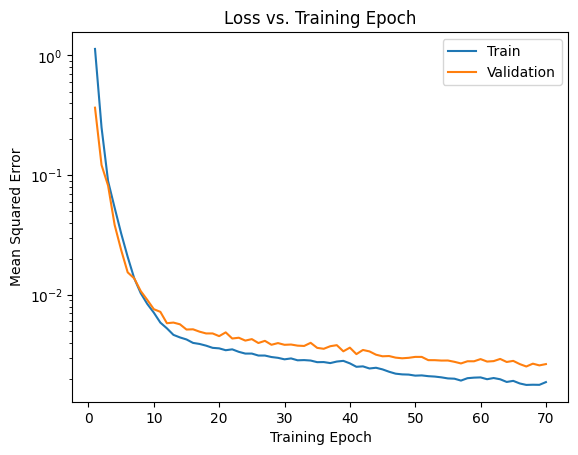

In [ ]:
num_epochs = 70 # define the number of epochs to train each model for.

# give lists of different weight decay, learning rate, and hidden size values to
# train models over

weight_decays = [0, 1e-4, 1e-3, 5e-3]
learning_rates = [5e-4, 1e-3]
hidden_sizes = [128, 256, 512]

# initialize the loss function. Here we are just using mean squared error loss.
criterion = nn.MSELoss()

cur_best_model = None # stores model with lowest validation loss
cur_best_val = 1000000 # large constant which will be replaced by validation loss
cur_best_param_dict = None # stores parameters of best model

for wd in weight_decays:
  for lr in learning_rates:
    for hidden_size in hidden_sizes:

      # initialize the model and optimizer with the parameters given above
      cur_model = SpreadLSTM(input_size=X_seq.shape[-1], hidden_size=hidden_size,
                             output_size=y.shape[-1], dropout=0,
                             num_layers=1, seq_len=seq_len).to(device)
      optimizer = optim.Adam(cur_model.parameters(), lr=lr)

      # train the model and keep track of relevant values
      (cur_model, cur_val_loss, cur_train_loss,
       cur_train_history, cur_val_history) = train_model(cur_model, optimizer,
                                                       num_epochs, train_loader, val_loader)

      # update the current best model and it's associated parameters to access
      # once the parameter search is complete
      if cur_val_loss <= cur_best_val:
        cur_best_model = cur_model
        cur_best_val = cur_val_loss
        cur_best_param_dict = {"train loss": cur_train_loss, "validation loss": cur_best_val,
                               "train history": cur_train_history, "validation history": cur_val_history,
                                "sequence length": seq_len, "learning rate": lr,
                                "weight decay": wd, "hidden size": hidden_size}

# ====== evaluate the model on test set ====== #

cur_best_model.eval() # set the model to evaluation mode
test_loss = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        test_outputs = cur_best_model(inputs)
        batch_loss = criterion(test_outputs, targets)

        test_loss += batch_loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)

# add the test loss to the parameter dictionary
cur_best_param_dict["test loss"] = test_loss

print("Training Loss:", cur_best_param_dict["train loss"])
print("Validation Loss:", cur_best_param_dict["validation loss"])
print("Test Loss:", cur_best_param_dict["test loss"])

# plot the loss curves
plt.figure()
plt.title("Loss vs. Training Epoch")
plt.ylabel("Mean Squared Error")
plt.xlabel("Training Epoch")
plt.yscale("log")
plt.plot(np.arange(num_epochs) + 1, cur_best_param_dict["train history"], label="Train")
plt.plot(np.arange(num_epochs) + 1, cur_best_param_dict["validation history"], label= "Validation")
plt.legend()

Save the model to the google drive folder for later use

In [ ]:
save_model_name = 'lstm_1day_20seqlen_512hidden.pt'
PATH = f"/content/drive/MyDrive/RJO_Internship/Models/{save_model_name}"

torch.save(cur_best_model.state_dict(), PATH)

Evaluate the model on test data, compute predicted versus actual rankings of each yield spread.

In [ ]:
model = SpreadLSTM(input_size=x_test.shape[-1],hidden_size=512,output_size=y_test.shape[-1],
                   dropout=0,num_layers=1,seq_len=seq_len)
model.load_state_dict(torch.load(PATH, map_location=device))
model.eval()

# convert the predicted tensor back to a NumPy array
predictions = model(x_test).detach().numpy()

# calculate the average predicted yield spread for each instrument
avg_predicted_spreads = np.mean(predictions, axis=0)
avg_actual_spreads = np.mean(y_test.detach().cpu().numpy(), axis=0)

# get instrument names
instrument_names = df_new.columns[:n]

# create a list of tuples with instrument names and their average predicted spreads
predicted_instrument_spreads = list(zip(instrument_names, avg_predicted_spreads))
actual_instrument_spreads = list(zip(instrument_names, avg_actual_spreads))

# rank all of the instruments based on their average predicted yield spreads
predicted_instrument_ranks = sorted(predicted_instrument_spreads, key=lambda x: x[1], reverse=True)
actual_instrument_ranks = sorted(actual_instrument_spreads, key=lambda x: x[1], reverse=True)

print("Average differnece between predicted and actual spread:",
      np.mean(np.abs(predictions - y_test.detach().cpu().numpy())))

# see how many mismatches occur in the predicted vs. actual rankings
mismatches = 0
for rank in range(len(predicted_instrument_spreads)):
  if predicted_instrument_spreads[rank][0] != actual_instrument_spreads[rank][0]:
    mismatches += 1
print("\nThere are " + str(mismatches) + " mismatches between the predicted and actual rankings.")

#print each instrument's ranking
print("\nPredicted Instrument Rankings:")
for rank, (instrument_name, spread) in enumerate(predicted_instrument_ranks):
    print(f"Rank {rank+1}: Instrument {instrument_name} ({spread})")

print("\nActual Instrument Rankings:")
for rank, (instrument_name, spread) in enumerate(actual_instrument_ranks):
    print(f"Rank {rank+1}: Instrument {instrument_name} ({spread})")

Average differnece between predicted and actual spread: 0.037155375

There are 0 mismatches between the predicted and actual rankings.

Predicted Instrument Rankings:
Rank 1: Instrument LRC30APR Index PX_LAST_USGG5YR Index PX_LAST (2.7075023651123047)
Rank 2: Instrument LRC30APR Index PX_LAST_GT5 Govt PX_LAST (2.7055823802948)
Rank 3: Instrument LRC30APR Index PX_LAST_MTGEFNCL Index PX_LAST (1.4660471677780151)
Rank 4: Instrument MTGEFNCL Index PX_LAST_USGG5YR Index PX_LAST (1.2438650131225586)
Rank 5: Instrument MTGEFNCL Index PX_LAST_GT5 Govt PX_LAST (1.2379268407821655)
Rank 6: Instrument GT5 Govt PX_LAST_USGG5YR Index PX_LAST (0.016798965632915497)
Rank 7: Instrument USGG5YR Index PX_LAST_GT5 Govt PX_LAST (0.0024508454371243715)
Rank 8: Instrument GT5 Govt PX_LAST_MTGEFNCL Index PX_LAST (-1.2439160346984863)
Rank 9: Instrument USGG5YR Index PX_LAST_MTGEFNCL Index PX_LAST (-1.2456328868865967)
Rank 10: Instrument MTGEFNCL Index PX_LAST_LRC30APR Index PX_LAST (-1.4609274864196777)
Ra